In [334]:
import pandas as pd
import missingno as msno
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from haversine import haversine, Unit

pd.set_option('display.max_columns', None)

In [335]:
df_all_housing_info = pd.read_csv('data/eda.csv')
df_all_housing_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   bedrooms       21597 non-null  float64
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  float64
 4   sqft_lot       21597 non-null  float64
 5   floors         21597 non-null  float64
 6   waterfront     19206 non-null  float64
 7   view           21534 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  float64
 11  sqft_basement  21145 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   17749 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  float64
 18  sqft_l

In [336]:
df_all_housing_info = df_all_housing_info.dropna(subset=['waterfront'])
df_all_housing_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19206 entries, 1 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             19206 non-null  int64  
 1   bedrooms       19206 non-null  float64
 2   bathrooms      19206 non-null  float64
 3   sqft_living    19206 non-null  float64
 4   sqft_lot       19206 non-null  float64
 5   floors         19206 non-null  float64
 6   waterfront     19206 non-null  float64
 7   view           19149 non-null  float64
 8   condition      19206 non-null  int64  
 9   grade          19206 non-null  int64  
 10  sqft_above     19206 non-null  float64
 11  sqft_basement  18791 non-null  float64
 12  yr_built       19206 non-null  int64  
 13  yr_renovated   15792 non-null  float64
 14  zipcode        19206 non-null  int64  
 15  lat            19206 non-null  float64
 16  long           19206 non-null  float64
 17  sqft_living15  19206 non-null  float64
 18  sqft_lot15 

In [337]:
df_ex_bth =df_all_housing_info.query('bathrooms<4 and sqft_lot >130000 and yr_built < 1965 and waterfront == 0.0')
df_all_specs = df_all_housing_info.query('bathrooms>=4 and sqft_lot >150000 and yr_built < 1965 and waterfront == 0.0')
df_all_specs

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price


In [338]:
df_all_housing_info.query('id==6762700020')

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price
7245,6762700020,6.0,8.0,12050.0,27600.0,2.5,0.0,3.0,4,13,8570.0,3480.0,1910,19870.0,98102,47.6298,-122.323,3940.0,8800.0,2014-10-13,7700000.0


In [339]:
ex_bth_id_list = df_ex_bth.id.tolist()
sm_house_list= []
close_hs_dict = {f"{id}": [] for id in ex_bth_id_list}
df_4_baths= df_all_housing_info[df_all_housing_info.bathrooms >4]

for i, row1 in df_ex_bth.iterrows():
    same_zip = df_4_baths[df_4_baths.zipcode ==row1.zipcode]
    for j,row2 in same_zip.iterrows():
        if 0<haversine((row1.lat, row1.long),(row2.lat,row2.long),unit=Unit.FEET)<5000 :
            close_hs_dict[f"{row1.id}"].append(row2.id)            
            sm_house_list.append(row2.id)
            
            print(haversine((row1.lat, row1.long),(row2.lat,row2.long)))




1.0368408967121279
1.3637284872075472
0.23310102352037473
0.6882413407001728
1.389904477622724
0.9872214075769749


In [340]:
has_cl_hs = {key:close_hs_dict[key]  for key in close_hs_dict if close_hs_dict[key]!=[]}
print(has_cl_hs)

{'824079032': [1824079073], '826069002': [7214700830], '2822059181': [2122059199], '822069029': [822069112], '2222039011': [1522039105], '4045900020': [226059096]}


In [341]:
df_has_cl_hs = df_ex_bth[df_ex_bth.id.astype(str).isin(has_cl_hs.keys())]

df_sm_house =df_all_housing_info[df_all_housing_info.id.astype(int).isin(sm_house_list)]
df_has_cl_hs['group']=3
df_sm_house['group']=1
df_all_specs['group']=2

combined_df = pd.concat([df_sm_house,df_has_cl_hs, df_all_specs])
df_has_cl_hs

/tmp/ipykernel_48250/2034109625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_has_cl_hs['group']=3
/tmp/ipykernel_48250/2034109625.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sm_house['group']=1


,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price,group
416,824079032,4.0,1.75,2085.0,174240.0,1.0,0.0,0.0,3,7,1610.0,475.0,1964,0.0,98024,47.5753,-121.950,2690.0,174240.0,2014-06-26,563500.0,3
4420,826069002,2.0,1.00,1350.0,368517.0,1.0,0.0,0.0,3,6,1350.0,0.0,1947,0.0,98077,47.7617,-122.061,2330.0,104108.0,2014-10-29,355000.0,3
5971,2822059181,5.0,2.00,1460.0,169448.0,1.5,0.0,0.0,3,6,1460.0,0.0,1910,0.0,98030,47.3714,-122.177,2250.0,6059.0,2015-04-13,306000.0,3
13203,822069029,3.0,2.75,2660.0,223027.0,1.0,0.0,0.0,3,8,1330.0,1330.0,1962,NaN,98038,47.4127,-122.071,1560.0,222591.0,2015-02-17,579000.0,3
14309,2222039011,5.0,1.75,2080.0,217800.0,1.0,0.0,0.0,5,7,2080.0,0.0,1963,NaN,98070,47.3884,-122.404,1670.0,213008.0,2014-11-03,480000.0,3
15775,4045900020,2.0,1.50,1440.0,136778.0,1.0,0.0,0.0,4,8,1140.0,300.0,1956,0.0,98072,47.7608,-122.118,1740.0,21600.0,2015-04-13,650000.0,3


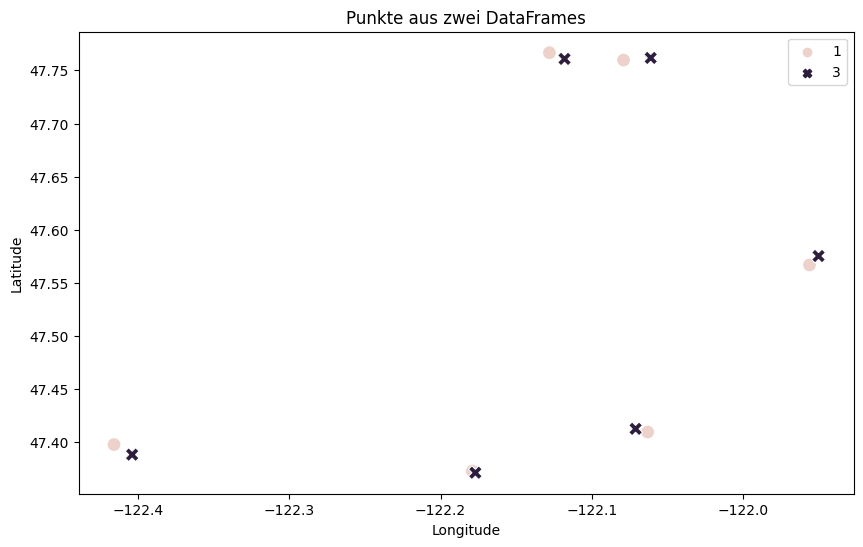

In [342]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='long', y='lat', hue='group', style='group', s=100)
plt.title('Punkte aus zwei DataFrames')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [343]:
# Erstelle eine Folium-Karte, zentriert auf die mittleren Koordinaten
map_center = [combined_df['lat'].mean(), combined_df['long'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Farben für Gruppen definieren
group_colors = {
    1: 'blue',
    2: 'red',
    3: 'orange'
}

# Häuser als Marker auf die Karte setzen
for _, row in combined_df.iterrows():
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=f"ID: {row['id']}, Year: {row['yr_built']} Bathrooms: {row['bathrooms']} Lot: {row['sqft_lot']}sqft  ",
        icon=folium.Icon(color=group_colors[row['group']])
    ).add_to(m)

# Karte anzeigen und speichern
m.save("combined_map.html")
m

In [344]:
df_all_housing_info.sqft_lot.sort_values().tail()

4437      982278.0
3945      982998.0
7762     1024068.0
17305    1164794.0
1717     1651359.0
Name: sqft_lot, dtype: float64